
GENERAL STATS:
total_games: 10
total_rounds: 2
players: ['da', 'se']
dice_frequency:    dice_value  frequency
0           2         21
1           4         18
2           3         17
3           5          5
4           1          4
5           6          3
forbidden_frequency: 4
forbidden_probability: 0.058823529411764705
average_totals_per_round:   player  average_total_per_round
0     da                     46.5
1     se                     48.0

PLAYER STATS:
player_summary:
  player  total_points  average_points  rounds_played
0     da            93        5.470588             17
1     se            96        5.647059             17
player_consistency:
  player  std_points
0     da    2.477843
1     se    2.977859
winners:
  player  games_won
0     da          5
1     se          3
zero_percentage:
  player  zero_percentage
0     da         0.014706
1     se         0.044118

FUTURE PREDICTIONS:
{'rounds_to_catch_up': {'da': 0.5483870967741935, 'se': 0}}


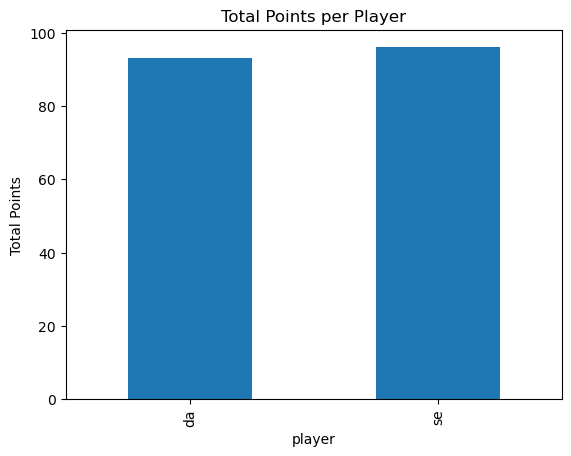

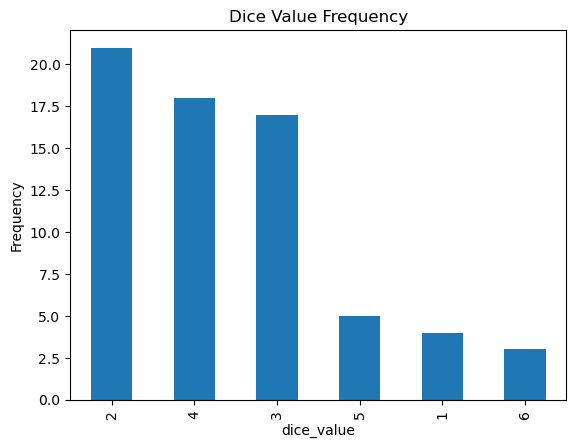

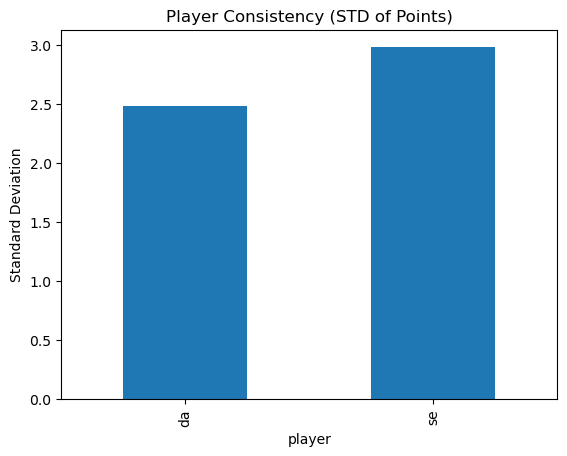

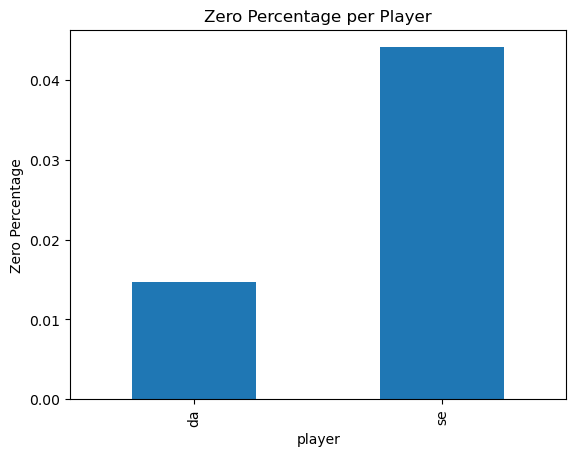

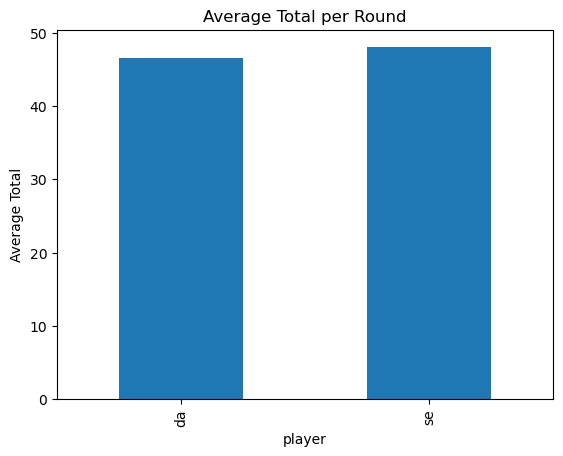

In [6]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Función para cargar los archivos JSON y transformarlos en un DataFrame
def load_games_from_json(directory):
    game_data = []

    # Leer cada archivo JSON en el directorio
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            with open(os.path.join(directory, filename), 'r') as file:
                game = json.load(file)

                # Expandir las rondas para análisis detallado
                for round_data in game['rounds']:
                    game_data.append({
                        'timestamp': game['timestamp'],
                        'players': game['gameConfig']['players'],
                        'rounds': game['gameConfig']['rounds'],
                        'dice': game['gameConfig']['dice'],
                        'forbiddenNumber': game['gameConfig']['forbiddenNumber'],
                        'round': round_data['round'],
                        'player': round_data['player'],
                        'diceResults': round_data['diceResults'],
                        'total': round_data['total'],
                        'winner': game.get('winner', None)  # Manejar casos donde no haya ganador definido
                    })
    
    return pd.DataFrame(game_data)

# Función para realizar análisis generales
def analyze_general_stats(df):
    general_analysis = {}

    # Resumen del juego
    general_analysis['total_games'] = df['timestamp'].nunique()
    general_analysis['total_rounds'] = df['round'].nunique()
    general_analysis['players'] = df['player'].unique().tolist()

    # Frecuencia de valores de dados
    dice_values = df['diceResults'].explode()
    dice_frequency = dice_values.value_counts().reset_index()
    dice_frequency.columns = ['dice_value', 'frequency']
    general_analysis['dice_frequency'] = dice_frequency

    # Frecuencia del número prohibido
    if 'forbiddenNumber' in df.columns and not df['forbiddenNumber'].isna().all():
        forbidden_number = df['forbiddenNumber'].iloc[0]  # Suponiendo que es constante por juego
        forbidden_frequency = (dice_values == forbidden_number).sum()
        general_analysis['forbidden_frequency'] = forbidden_frequency
        general_analysis['forbidden_probability'] = forbidden_frequency / dice_values.count()
    else:
        general_analysis['forbidden_frequency'] = 0
        general_analysis['forbidden_probability'] = 0.0

    # Promedio de los totales por ronda por jugador
    round_totals = df.groupby(['round', 'player'])['total'].sum().reset_index()
    average_totals_per_round = round_totals.groupby('player')['total'].mean().reset_index()
    average_totals_per_round.columns = ['player', 'average_total_per_round']
    general_analysis['average_totals_per_round'] = average_totals_per_round

    return general_analysis

# Función para realizar análisis por jugador
def analyze_player_stats(df):
    player_analysis = {}

    # Puntos totales y promedio por jugador
    player_summary = df.groupby('player').agg(
        total_points=('total', 'sum'),
        average_points=('total', 'mean'),
        rounds_played=('round', 'count')
    ).reset_index()
    player_analysis['player_summary'] = player_summary

    # Análisis de consistencia
    player_std = df.groupby('player')['total'].std().reset_index()
    player_std.columns = ['player', 'std_points']
    player_analysis['player_consistency'] = player_std

    # Ganador por juego
    if 'winner' in df.columns:
        winners = df.groupby('timestamp')['winner'].first().value_counts().reset_index()
        winners.columns = ['player', 'games_won']
        player_analysis['winners'] = winners

    # Calcular el porcentaje de ceros
    total_throws = df['diceResults'].apply(len).sum()
    zero_counts = df[df['total'] == 0].groupby('player').size().reindex(df['player'].unique(), fill_value=0)
    zero_percentage = (zero_counts / total_throws).reset_index()
    zero_percentage.columns = ['player', 'zero_percentage']
    player_analysis['zero_percentage'] = zero_percentage

    return player_analysis

# Función para realizar predicciones y análisis adicional
def predict_future(df, player_analysis):
    predictions = {}

    # Probabilidad de que un jugador específico gane si se añaden más rondas
    player_avg_points = player_analysis['player_summary'].set_index('player')['average_points']
    current_totals = player_analysis['player_summary'].set_index('player')['total_points']

    max_points = current_totals.max()
    predictions['rounds_to_catch_up'] = {}
    for player, total in current_totals.items():
        avg_points = player_avg_points[player]
        if avg_points > 0:
            predictions['rounds_to_catch_up'][player] = max(0, (max_points - total) / avg_points)
        else:
            predictions['rounds_to_catch_up'][player] = float('inf')

    return predictions

# Función para generar gráficos
def plot_analysis(general_analysis, player_analysis):
    # Puntos totales por jugador
    player_summary = player_analysis['player_summary']
    player_summary.plot(x='player', y='total_points', kind='bar', title='Total Points per Player', legend=False)
    plt.ylabel('Total Points')
    plt.show()

    # Distribución de valores de dados
    dice_frequency = general_analysis['dice_frequency']
    dice_frequency.plot(x='dice_value', y='frequency', kind='bar', title='Dice Value Frequency', legend=False)
    plt.ylabel('Frequency')
    plt.show()

    # Consistencia por jugador
    consistency = player_analysis['player_consistency']
    consistency.plot(x='player', y='std_points', kind='bar', title='Player Consistency (STD of Points)', legend=False)
    plt.ylabel('Standard Deviation')
    plt.show()

    # Porcentaje de ceros por jugador
    zero_percentage = player_analysis['zero_percentage']
    zero_percentage.plot(x='player', y='zero_percentage', kind='bar', title='Zero Percentage per Player', legend=False)
    plt.ylabel('Zero Percentage')
    plt.show()

    # Promedio de totales por ronda
    average_totals_per_round = general_analysis['average_totals_per_round']
    average_totals_per_round.plot(x='player', y='average_total_per_round', kind='bar', title='Average Total per Round', legend=False)
    plt.ylabel('Average Total')
    plt.show()

# Directorio donde están los archivos JSON
directory = "./game_files"

# Cargar los datos y realizar el análisis
game_df = load_games_from_json(directory)
general_stats = analyze_general_stats(game_df)
player_stats = analyze_player_stats(game_df)
future_predictions = predict_future(game_df, player_stats)

# Mostrar resultados
print("\nGENERAL STATS:")
for key, value in general_stats.items():
    print(f"{key}: {value}")

print("\nPLAYER STATS:")
for key, value in player_stats.items():
    print(f"{key}:\n{value}")

print("\nFUTURE PREDICTIONS:")
print(future_predictions)

# Graficar análisis
plot_analysis(general_stats, player_stats)
